In [1]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp
from matplotlib import rc
import matplotlib as mpl

sys.path.append("../scripts")
sys.path.append("..")

from extract import *


/home/jpdef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


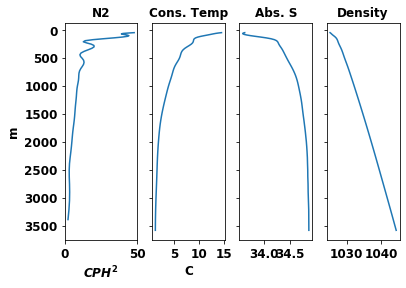

In [2]:
"""
Read data and compute means
"""
path = os.path.join("..","matlab",filename)

table = read_table(path)
N2 = extract_node(table,'N2')
T  = extract_node(table,'T')
W  = extract_node(table,'T')
S  = extract_node(table,'S')
Z  = extract_node(table,'z').flatten()

#Compute the mean stratification
DSL = slice(15,80) # depth slice
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean[DSL],T_mean[DSL],Z[DSL])

#Plot it
f, ax = plt.subplots(1,4,sharey=True)
ax[0].invert_yaxis()
ax[0].set_title('N2')
ax[0].set_xlabel('$CPH^2$')
ax[0].set_ylabel('m')
ax[0].plot(3600*np.sqrt(N2_mean[DSL]),Z[DSL])
ax[1].set_title('Cons. Temp')
ax[1].set_xlabel('C')
ax[1].plot(T_mean[DSL],Z[DSL]) 
ax[2].set_title('Salinity')
ax[2].set_title('Abs. S')
ax[2].plot(S_mean[DSL],Z[DSL]) 
ax[3].set_title('Density')
#ax[3].set_xlabel('$\frac{kg}{m^3}$')
ax[3].plot(R_mean,Z[DSL] ) 

In [3]:
#Define a slice
sl = (slice(0,None),DSL,slice(0,None),slice(0,None))

#Subsample matrices
TP = T[sl]
SP = S[sl]
NP = N2[sl]

TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,LAT,LON])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(TP.shape)

#Compute Density from state variables
RP = sw.eos80.dens(SP,TP,AX['z'])

#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z[DSL])
DZ   = zofr(RP) - AX['z']

#Plot anomalies
#f,ax = plt.subplots(1,2)
#for i in range(50):
#    ax[0].plot(DZ[i,:,0,0],AX[i,:,0,0]['z'])

#ax[0].invert_yaxis()

#for i in range(30,40):
#    ax[1].plot(AX[:,i,0,0]['t'],DZ[:,i,0,0] )

Text(0, 0.5, '$m^2/cpd$')

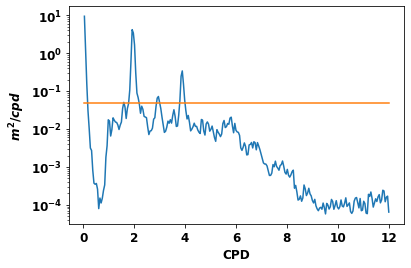

In [7]:
#Depth average time spectrum
DZ_AVG = DZ.mean(axis=(1,2,3))
f,pxx = sig.welch(DZ_AVG,fs=24,nperseg=512)
plt.semilogy(f[1:],pxx[1:])
plt.semilogy(f[1:],.05*np.ones(len(f[1:])))
plt.xlabel('CPD')
plt.ylabel('$m^2/cpd$')

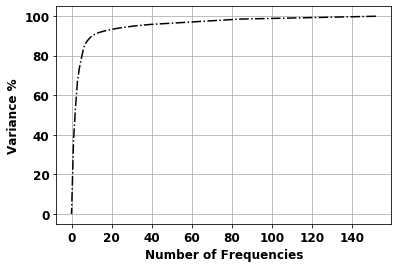

In [8]:
@np.vectorize
def power_percentage(threshold):
    return 100*np.sum( pxx[ np.where( pxx > threshold )] ) / np.sum(pxx)

@np.vectorize
def number_of_parameters(threshold):
    return len(f[np.where(pxx>threshold)])

thres = np.linspace(1e-3,1e1,1000)
plt.plot(number_of_parameters(thres),power_percentage(thres),'k-.')
plt.ylabel('Variance %')
plt.xlabel('Number of Frequencies')
plt.grid(True)

In [18]:
ff = f[np.where(pxx[1:] > 0.02 )]
print(len(ff))
print(ff)

41
[0.       0.046875 0.09375  0.140625 1.5      1.546875 1.59375  1.6875
 1.734375 1.78125  1.828125 1.875    1.921875 1.96875  2.015625 2.0625
 2.109375 2.15625  2.203125 2.25     2.296875 2.34375  2.390625 2.8125
 2.859375 2.90625  2.953125 3.       3.046875 3.46875  3.515625 3.5625
 3.703125 3.75     3.796875 3.84375  3.890625 3.9375   3.984375 4.078125
 5.765625]


19.0

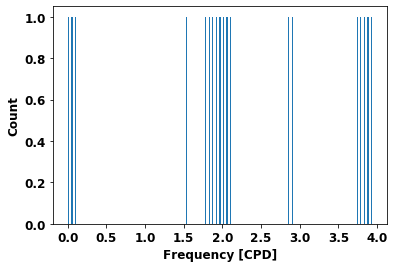

In [11]:
h = plt.hist(f[np.where(pxx[1:] > 0.05 )],bins=len(pxx))
plt.ylabel('Count')
plt.xlabel('Frequency [CPD]')
np.sum(h[0])

Text(0.5, 1.0, 'Spectrum of Depth Average Vertical Velocity')

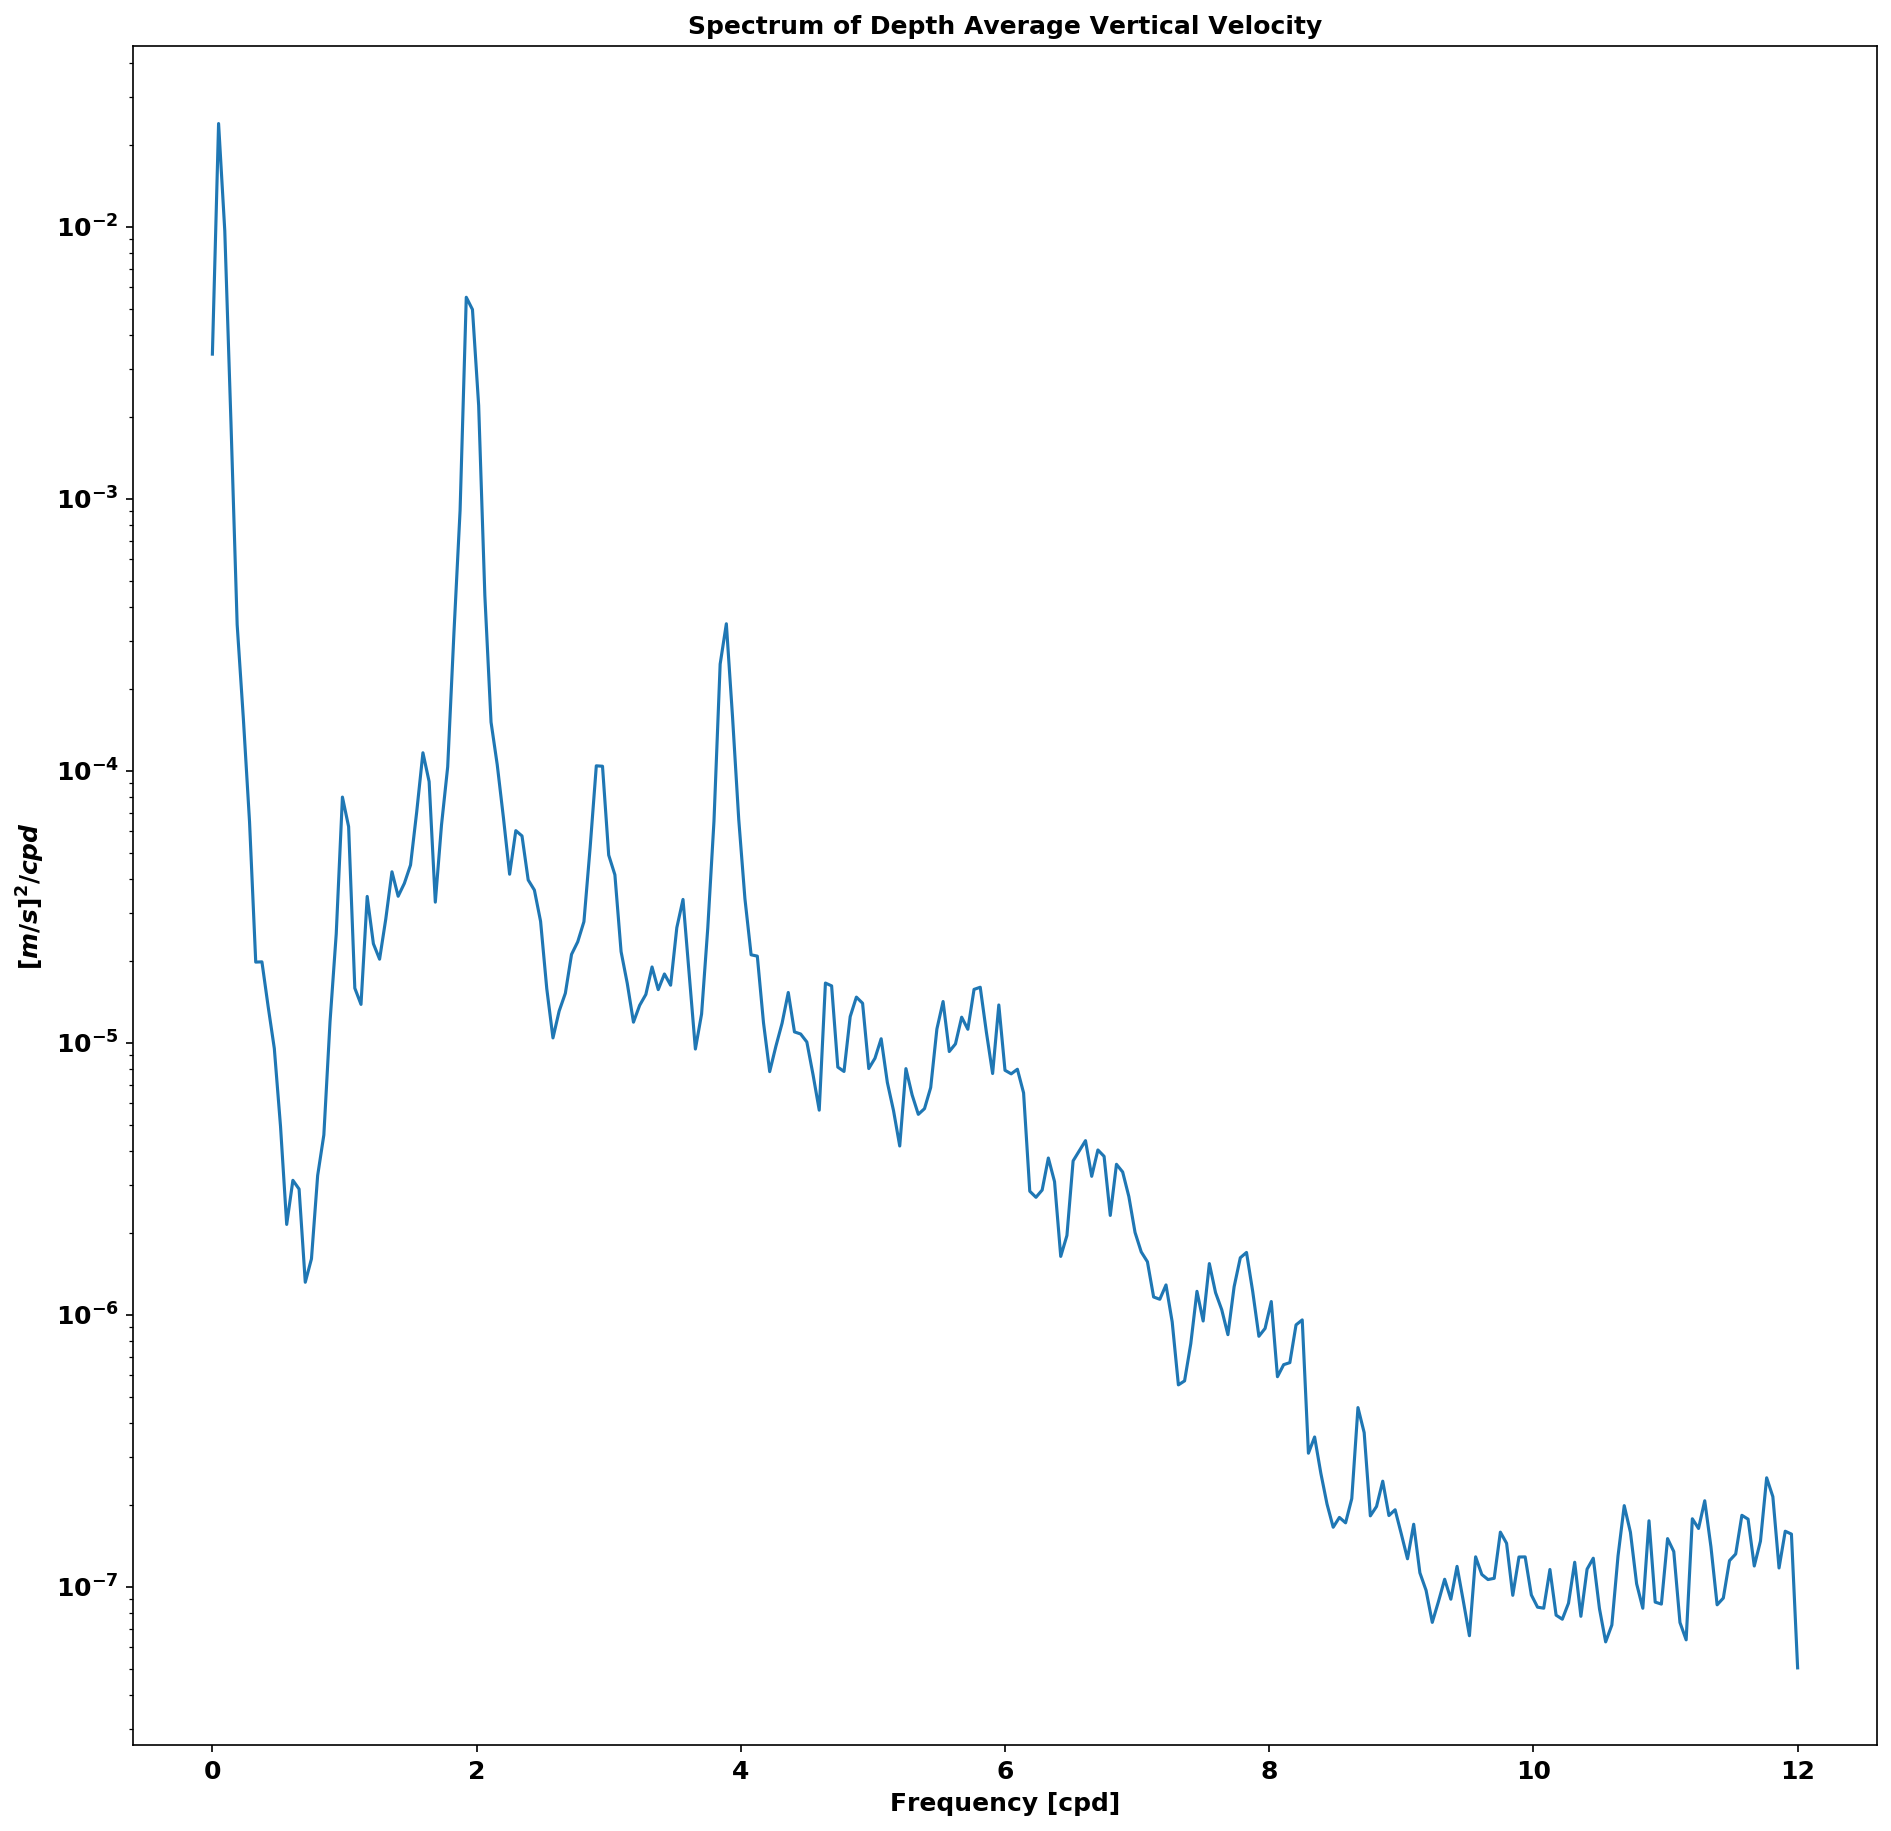

In [14]:
#Depth average time spectrum
W_AVG = W.mean(axis=(1,2,3))
f,pxx = sig.welch(W_AVG,fs=24,nperseg=512)
plt.figure(figsize=(15,15),dpi=150)
plt.semilogy(f,pxx)
plt.xlabel('Frequency [cpd]')
plt.ylabel('$[m/s]^2/cpd$')
plt.title('Spectrum of Depth Average Vertical Velocity')

Text(0.5, 1.0, 'Spectrum of W vs Depth')

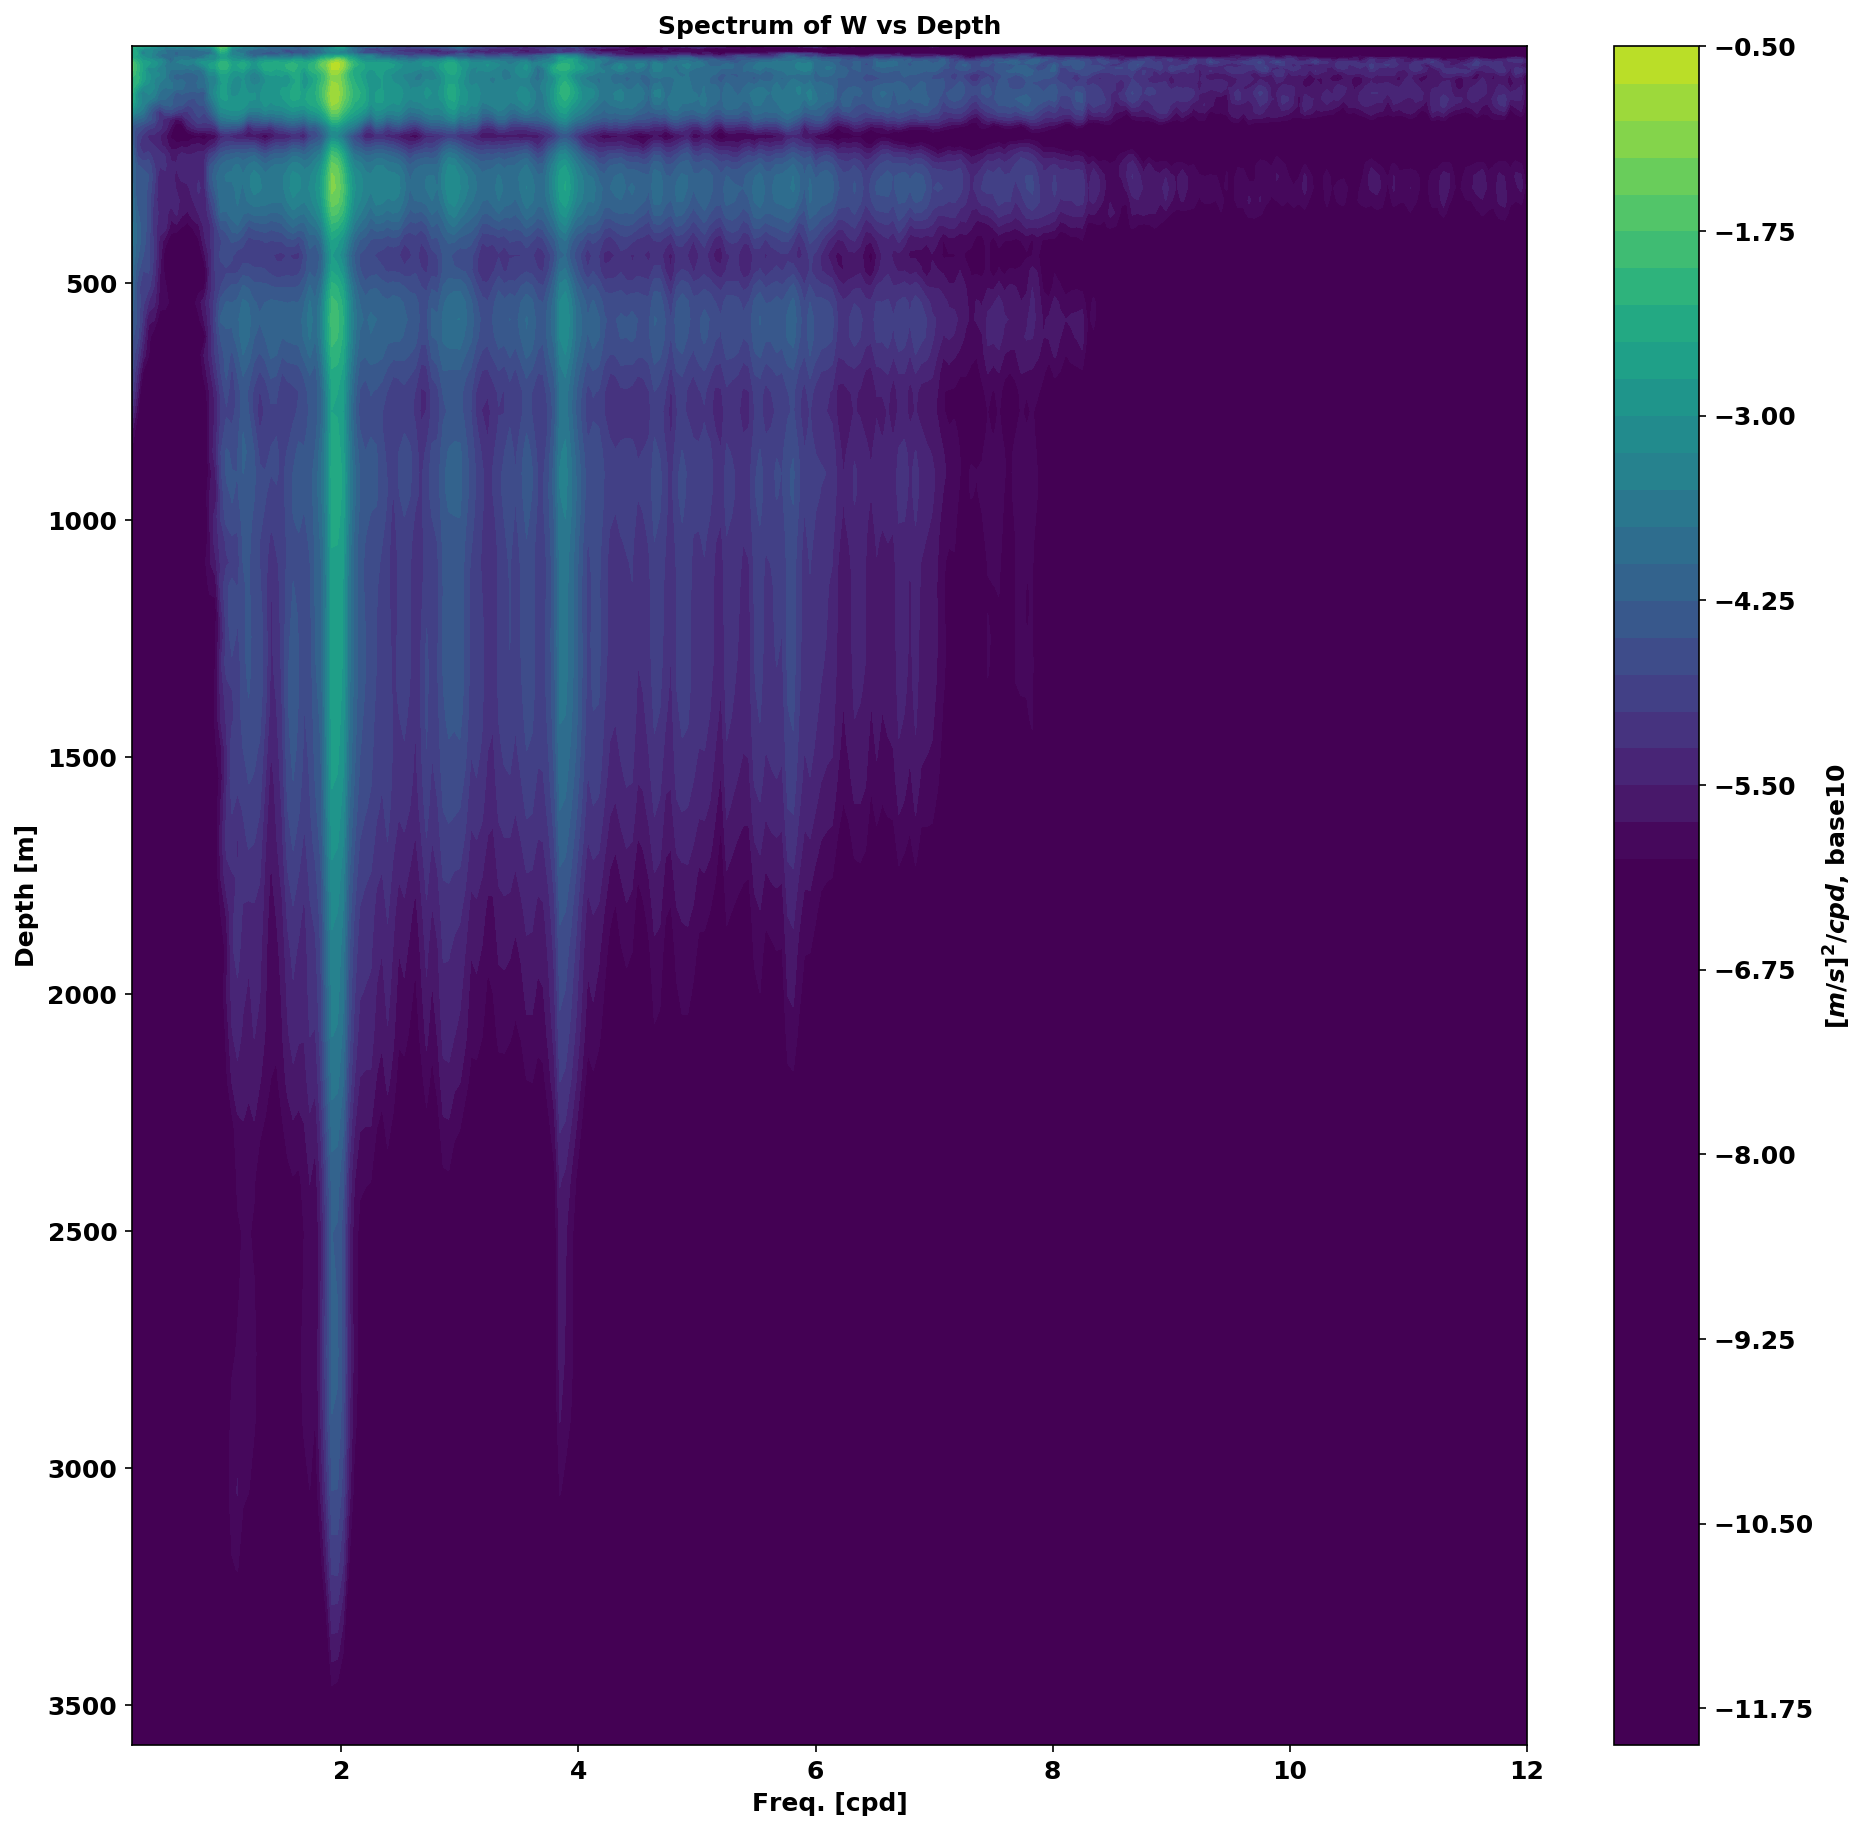

In [18]:
W_SP_AVG = W.mean(axis=(2,3))
f, pxx = sig.welch(W_SP_AVG,fs=24,nperseg=512,axis=(0))
plt.figure(figsize=(15,15),dpi=150)
plt.contourf(f[5:],Z[0:80], np.log10(pxx[5:,0:80].T),levels=50)
plt.gca().invert_yaxis()
plt.xlabel('Freq. [cpd]')
plt.ylabel('Depth [m]')
plt.colorbar(label='$[m/s]^2/cpd$, base10')
plt.clim(-6,0)
plt.title('Spectrum of W vs Depth')

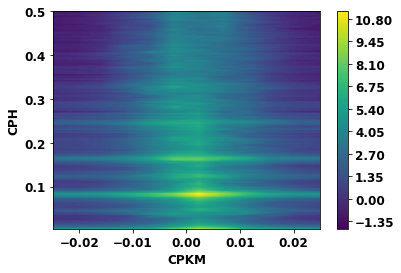

In [16]:
#%matplotlib widget
import COR.utils as cor
#Compute 2D power spectra
#DZ_AVG = DZ.mean(axis=(1,3))
DZ_AVG = DZ[:,30,1,:]
RF_SEG,CF_SEG,D_SPEC = cor.psd_2D(DZ_AVG,SEGS=(10,1),FS=(1,1/20))
f , ax  = plt.subplots()
p = ax.contourf(CF_SEG.T,RF_SEG.T,np.log(D_SPEC.T) ,levels=100)
ax.set_xlabel('CPKM')
ax.set_ylabel('CPH')
f.colorbar(p)